# PaSST Training - OpenMIC Only (Baseline)

This notebook trains the PaSST model on **only the OpenMIC dataset** (without synthetic data) for comparison purposes.

Use this to compare against the model trained on OpenMIC + Synthetic data.


In [1]:
!pip -q install torchcodec hear21passt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.3 MB/s eta 0:00:00


In [2]:
import torch, torchaudio, pandas as pd, numpy as np
from pathlib import Path

print("torch:", torch.__version__)
print("torchaudio:", torchaudio.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

# Speed knobs (safe on A100)
torch.backends.cudnn.benchmark = True
try:
    torch.set_float32_matmul_precision("high")
except Exception:
    pass


torch: 2.9.0+cu126
torchaudio: 2.9.0+cu126
cuda available: True
gpu: NVIDIA A100-SXM4-80GB


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [3]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


## 1. Copy OpenMIC Data to Local (Faster I/O)


In [4]:
# Copy only OpenMIC dataset (no synthetic data)
!mkdir -p /content/openmic-2018-2

# Copy OpenMIC audio + metadata
!cp -r "/content/drive/MyDrive/openmic-2018-2/audio" "/content/openmic-2018-2/"
!cp "/content/drive/MyDrive/openmic-2018-2/openmic-2018-aggregated-labels.csv" "/content/openmic-2018-2/" || true
!cp "/content/drive/MyDrive/openmic-2018-2/openmic-2018-metadata.csv" "/content/openmic-2018-2/" || true

!du -sh /content/openmic-2018-2/audio || true


2.5G	/content/openmic-2018-2/audio


## 2. Load and Process OpenMIC Labels


In [5]:
TAGS = [
    "accordion","banjo","bass","cello","clarinet","cymbals","drums","flute","guitar","mallet_percussion",
    "mandolin","organ","piano","saxophone","synthesizer","trombone","trumpet","ukulele","violin","voice"
]
Y_COLS = [f"y_{t}" for t in TAGS]
M_COLS = [f"m_{t}" for t in TAGS]

OPENMIC_DIR = Path("/content/openmic-2018-2")
openmic_labels_path = OPENMIC_DIR / "openmic-2018-aggregated-labels.csv"
openmic_audio_dir = OPENMIC_DIR / "audio"

# Load long-format labels
df_long = pd.read_csv(openmic_labels_path)
print("Loaded long labels:", df_long.shape)
print("Columns:", df_long.columns.tolist())


Loaded long labels: (41534, 4)
Columns: ['sample_key', 'instrument', 'relevance', 'num_responses']


In [6]:
# Filter to only instruments in our tag set
df_long["instrument"] = df_long["instrument"].astype(str)
df_long = df_long[df_long["instrument"].isin(TAGS)].copy()

# Convert relevance -> binary label (threshold = 0.5)
THRESH = 0.5
df_long["y"] = (df_long["relevance"] >= THRESH).astype(int)

# Pivot to wide format: one row per sample_key, one column per instrument
df = (
    df_long.pivot_table(index="sample_key", columns="instrument", values="y", aggfunc="max", fill_value=0)
    .reset_index()
)

# Rename columns to y_<tag>
df = df.rename(columns={t: f"y_{t}" for t in TAGS if t in df.columns})

# Ensure all y_ columns exist
for t in TAGS:
    col = f"y_{t}"
    if col not in df.columns:
        df[col] = 0

# Add mask columns (m_<tag> = 1 for all OpenMIC samples)
for t in TAGS:
    df[f"m_{t}"] = 1

df["source"] = "openmic"
print("OpenMIC wide labels:", df.shape)


OpenMIC wide labels: (20000, 42)


In [7]:
# Build file paths - OpenMIC audio is stored in subdirectories based on first 3 chars of sample_key
# e.g., sample_key "000046_3840" -> audio/000/000046_3840.ogg

# Find all .ogg files and build lookup
ogg_paths = list(openmic_audio_dir.rglob("*.ogg"))
print("Found .ogg files:", len(ogg_paths))

# Build lookup: "132269_7680.ogg" -> "/content/openmic-2018-2/audio/132/132269_7680.ogg"
ogg_map = {p.name: str(p.resolve()) for p in ogg_paths}

# Map sample_key to path
df["filename"] = df["sample_key"].astype(str) + ".ogg"
df["path"] = df["filename"].map(ogg_map)

missing = df["path"].isna().sum()
print("Missing paths:", missing)
assert missing == 0, f"Missing {missing} audio files!"


Found .ogg files: 20000
Missing paths: 0


In [8]:
# Sanity check
sample = df.sample(500, random_state=0)
missing = sum(not Path(p).exists() for p in sample["path"])
print("Missing paths in sample(500):", missing)
print("Dataset size:", len(df))
print("\nTag prevalence (positive rate):")
print(df[Y_COLS].mean().sort_values(ascending=False).head(10))


Missing paths in sample(500): 0
Dataset size: 20000

Tag prevalence (positive rate):
instrument
y_violin         0.05865
y_piano          0.05850
y_trumpet        0.05730
y_guitar         0.05690
y_saxophone      0.05675
y_cymbals        0.05555
y_drums          0.05530
y_synthesizer    0.05455
y_voice          0.04940
y_trombone       0.04320
dtype: float64


## 3. Train/Validation/Test Split


In [9]:
SPLIT_FILE = Path("/content/drive/MyDrive/deep_learning/splits_openmic_only_v1.npz")

def make_split_indices(n, seed=42, train=0.8, valid=0.1, test=0.1):
    assert abs(train+valid+test-1.0) < 1e-9
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    n_train = int(train*n)
    n_valid = int(valid*n)
    train_idx = idx[:n_train]
    valid_idx = idx[n_train:n_train+n_valid]
    test_idx  = idx[n_train+n_valid:]
    return train_idx, valid_idx, test_idx

if SPLIT_FILE.exists():
    sp = np.load(SPLIT_FILE)
    train_idx, valid_idx, test_idx = sp["train_idx"], sp["valid_idx"], sp["test_idx"]
    print("Loaded split from:", SPLIT_FILE)
else:
    train_idx, valid_idx, test_idx = make_split_indices(len(df), seed=42)
    np.savez(SPLIT_FILE, train_idx=train_idx, valid_idx=valid_idx, test_idx=test_idx)
    print("Saved split to:", SPLIT_FILE)

print("Train/Valid/Test sizes:", len(train_idx), len(valid_idx), len(test_idx))


Loaded split from: /content/drive/MyDrive/deep_learning/splits_openmic_only_v1.npz
Train/Valid/Test sizes: 16000 2000 2000


## 4. Dataset and DataLoader


In [10]:
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader

TARGET_SR = 32000
CLIP_SECONDS = 10
TARGET_LEN = TARGET_SR * CLIP_SECONDS

class AudioMultiLabelDS(Dataset):
    def __init__(self, df, indices):
        self.df = df.iloc[indices].reset_index(drop=True)
        self.paths = self.df["path"].tolist()
        self.y = self.df[Y_COLS].to_numpy(dtype=np.float32)
        self.m = self.df[M_COLS].to_numpy(dtype=np.float32)
        self.src = self.df["source"].tolist()

    def __len__(self):
        return len(self.df)

    def _load_audio(self, path: str):
        wav, sr = torchaudio.load(path)  # [C,T]
        if wav.ndim == 2 and wav.size(0) > 1:
            wav = wav.mean(dim=0, keepdim=True)  # mono [1,T]
        if sr != TARGET_SR:
            wav = torchaudio.functional.resample(wav, sr, TARGET_SR)

        # crop/pad to 10s
        T = wav.size(1)
        if T < TARGET_LEN:
            pad = TARGET_LEN - T
            wav = torch.nn.functional.pad(wav, (0, pad))
        elif T > TARGET_LEN:
            wav = wav[:, :TARGET_LEN]

        return wav.squeeze(0)  # [T]

    def __getitem__(self, idx):
        path = self.paths[idx]
        wav = self._load_audio(path)
        y = torch.from_numpy(self.y[idx])
        m = torch.from_numpy(self.m[idx])
        return wav, y, m, self.src[idx]

def collate(batch):
    wav, y, m, src = zip(*batch)
    return torch.stack(wav, 0), torch.stack(y, 0), torch.stack(m, 0), list(src)

BATCH_SIZE = 32  # safe starting point on A100
NUM_WORKERS = 4

train_ds = AudioMultiLabelDS(df, train_idx)
valid_ds = AudioMultiLabelDS(df, valid_idx)
test_ds  = AudioMultiLabelDS(df, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS,
                          pin_memory=True, drop_last=True, collate_fn=collate)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                          pin_memory=True, drop_last=False, collate_fn=collate)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS,
                          pin_memory=True, drop_last=False, collate_fn=collate)

print("train/valid/test:", len(train_ds), len(valid_ds), len(test_ds))


train/valid/test: 16000 2000 2000


## 5. Build PaSST Model


In [11]:
from hear21passt.base import get_basic_model, get_model_passt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Wrapper includes mel frontend + transformer
model = get_basic_model(mode="logits")

# Replace transformer with a 20-class head (pretrained backbone + new classifier head)
model.net = get_model_passt(arch="passt_s_swa_p16_128_ap476", n_classes=len(TAGS))

model = model.to(DEVICE)
print("Model loaded successfully!")
print(f"Number of classes: {len(TAGS)}")




 Loading PASST TRAINED ON AUDISET 




100%|██████████| 329M/329M [05:29<00:00, 1.05MB/s]


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
     

## 6. Loss Function and Metrics


In [12]:
import time

bce = torch.nn.BCEWithLogitsLoss(reduction="none")

@torch.no_grad()
def macro_f1_from_logits(logits, y_true, mask, thr=0.5, eps=1e-9):
    # logits,y_true,mask: [N,C]
    probs = torch.sigmoid(logits)
    pred = (probs >= thr).float()

    # Apply mask: only evaluate where mask==1
    y_true = y_true * mask
    pred = pred * mask

    tp = (pred * y_true).sum(dim=0)
    fp = (pred * (1 - y_true)).sum(dim=0)
    fn = ((1 - pred) * y_true).sum(dim=0)

    precision = tp / (tp + fp + eps)
    recall    = tp / (tp + fn + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)

    # Avoid classes with zero valid labels in mask (rare here, but safe)
    valid = (mask.sum(dim=0) > 0).float()
    macro = (f1 * valid).sum() / (valid.sum() + eps)
    return macro.item()

def masked_bce_loss(logits, y, m):
    per = bce(logits, y)            # [B,C]
    per = per * m                   # mask out unknown/unsupervised
    denom = m.sum().clamp(min=1.0)
    return per.sum() / denom


## 7. Smoke Test


In [ ]:
model.train()
wav, y, m, src = next(iter(train_loader))
wav = wav.to(DEVICE)        # [B, T] @ 32kHz
y   = y.to(DEVICE)
m   = m.to(DEVICE)

with torch.no_grad():
    logits = model(wav)
print("wav:", tuple(wav.shape), "logits:", tuple(logits.shape),
      "finite:", torch.isfinite(logits).all().item(),
      "logits min/max:", float(logits.min()), float(logits.max()))


/usr/local/lib/python3.12/dist-packages/torch/functional.py:681: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:875.)
  return _VF.stft(  # type: ignore[attr-defined]
/usr/local/lib/python3.12/dist-packages/hear21passt/models/preprocess.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


x torch.Size([32, 1, 128, 1000])
self.norm(x) torch.Size([32, 768, 12, 99])
 patch_embed :  torch.Size([32, 768, 12, 99])
 self.time_new_pos_embed.shape torch.Size([1, 768, 1, 99])
 self.freq_new_pos_embed.shape torch.Size([1, 768, 12, 1])
X flattened torch.Size([32, 1188, 768])
 self.new_pos_embed.shape torch.Size([1, 2, 768])
 self.cls_tokens.shape torch.Size([32, 1, 768])
 self.dist_token.shape torch.Size([32, 1, 768])
 final sequence x torch.Size([32, 1190, 768])


/usr/local/lib/python3.12/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*1000) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


 after 12 atten blocks x torch.Size([32, 1190, 768])
forward_features torch.Size([32, 768])
head torch.Size([32, 20])
wav: (32, 320000) logits: (32, 20) finite: True logits min/max: -2.211968421936035 1.7902002334594727


## 8. Training Loop


In [13]:
from torch.optim import AdamW
from torch.cuda.amp import autocast, GradScaler

EPOCHS = 20
LR = 1e-4
WD = 1e-2
PATIENCE = 6
PRINT_EVERY = 50

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)
scaler = GradScaler(enabled=(DEVICE=="cuda"))

# Save to different path for comparison
BEST_PATH = Path("/content/drive/MyDrive/model_weights/finetuning/passt_openmic_only_best.pth")
BEST_PATH.parent.mkdir(parents=True, exist_ok=True)

history = {"train_loss": [], "val_loss": [], "val_f1_02": [], "val_f1_05": []}

def run_eval(loader):
    model.eval()
    losses = []
    all_logits, all_y, all_m = [], [], []

    with torch.no_grad():
        for wav, y, m, _ in loader:
            wav = wav.to(DEVICE, non_blocking=True)
            y   = y.to(DEVICE, non_blocking=True)
            m   = m.to(DEVICE, non_blocking=True)
            logits = model(wav)
            loss = masked_bce_loss(logits, y, m)
            losses.append(loss.item())

            all_logits.append(logits.detach().cpu())
            all_y.append(y.detach().cpu())
            all_m.append(m.detach().cpu())

    all_logits = torch.cat(all_logits, 0)
    all_y = torch.cat(all_y, 0)
    all_m = torch.cat(all_m, 0)
    val_loss = float(np.mean(losses))
    f1_02 = macro_f1_from_logits(all_logits, all_y, all_m, thr=0.2)
    f1_05 = macro_f1_from_logits(all_logits, all_y, all_m, thr=0.5)
    return val_loss, f1_02, f1_05

best_val = float("inf")
bad = 0

for epoch in range(1, EPOCHS+1):
    model.train()
    t0 = time.time()
    step_times = []
    losses = []

    n_steps = len(train_loader)
    for step, (wav, y, m, _) in enumerate(train_loader, start=1):
        ts = time.time()

        wav = wav.to(DEVICE, non_blocking=True)
        y   = y.to(DEVICE, non_blocking=True)
        m   = m.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(DEVICE=="cuda")):
            logits = model(wav)
            loss = masked_bce_loss(logits, y, m)

        if not torch.isfinite(loss):
            print(f"[STOP] Non-finite loss at epoch {epoch} step {step}: {loss.item()}")
            raise RuntimeError("Loss became NaN/Inf. Reduce LR or disable AMP.")

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())
        step_times.append(time.time() - ts)

        if step % PRINT_EVERY == 0:
            sec = float(np.mean(step_times[-PRINT_EVERY:]))
            eta = (n_steps - step) * sec / 60.0
            print(f"epoch {epoch} step {step}/{n_steps} loss {np.mean(losses[-PRINT_EVERY:]):.4f} sec/step {sec:.3f} ETA {eta:.1f}m")

    train_loss = float(np.mean(losses))
    val_loss, f1_02, f1_05 = run_eval(valid_loader)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_f1_02"].append(f1_02)
    history["val_f1_05"].append(f1_05)

    print(f"epoch {epoch} DONE | {(time.time()-t0)/60:.1f}m | VAL loss {val_loss:.4f} | VAL macro-F1@0.2 {f1_02:.4f} | @0.5 {f1_05:.4f}")

    # checkpoint by val loss
    if val_loss < best_val - 1e-6:
        best_val = val_loss
        bad = 0
        torch.save(model.state_dict(), BEST_PATH)
        print("Saved best:", str(BEST_PATH), "val_loss:", best_val)
    else:
        bad += 1
        if bad >= PATIENCE:
            print(f"Early stopping. Best val_loss: {best_val:.4f}")
            break


/tmp/ipython-input-3799174162.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE=="cuda"))
/tmp/ipython-input-3799174162.py:63: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE=="cuda")):
/usr/local/lib/python3.12/dist-packages/torch/functional.py:681: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:875.)
  return _VF.stft(  # type: ignore[attr-defined]
/usr/local/lib/python3.12/dist-packages/hear21passt/models/preprocess.py:71: FutureWarning: `torch.cuda.amp.aut

x torch.Size([32, 1, 128, 1000])
self.norm(x) torch.Size([32, 768, 12, 99])
 patch_embed :  torch.Size([32, 768, 12, 99])
 self.time_new_pos_embed.shape torch.Size([1, 768, 1, 99])
 self.freq_new_pos_embed.shape torch.Size([1, 768, 12, 1])
X flattened torch.Size([32, 1188, 768])
 self.new_pos_embed.shape torch.Size([1, 2, 768])
 self.cls_tokens.shape torch.Size([32, 1, 768])
 self.dist_token.shape torch.Size([32, 1, 768])
 final sequence x torch.Size([32, 1190, 768])


/usr/local/lib/python3.12/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*1000) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


 after 12 atten blocks x torch.Size([32, 1190, 768])
forward_features torch.Size([32, 768])
head torch.Size([32, 20])
epoch 1 step 50/500 loss 0.1667 sec/step 0.733 ETA 5.5m
epoch 1 step 100/500 loss 0.0976 sec/step 0.664 ETA 4.4m
epoch 1 step 150/500 loss 0.0926 sec/step 0.665 ETA 3.9m
epoch 1 step 200/500 loss 0.0870 sec/step 0.665 ETA 3.3m
epoch 1 step 250/500 loss 0.0844 sec/step 0.665 ETA 2.8m
epoch 1 step 300/500 loss 0.0788 sec/step 0.665 ETA 2.2m
epoch 1 step 350/500 loss 0.0833 sec/step 0.665 ETA 1.7m
epoch 1 step 400/500 loss 0.0806 sec/step 0.665 ETA 1.1m
epoch 1 step 450/500 loss 0.0763 sec/step 0.665 ETA 0.6m
epoch 1 step 500/500 loss 0.0796 sec/step 0.665 ETA 0.0m
epoch 1 DONE | 5.9m | VAL loss 0.0775 | VAL macro-F1@0.2 0.6248 | @0.5 0.5876
Saved best: /content/drive/MyDrive/model_weights/finetuning/passt_openmic_only_best.pth val_loss: 0.0775339063552637
epoch 2 step 50/500 loss 0.0673 sec/step 0.665 ETA 5.0m
epoch 2 step 100/500 loss 0.0654 sec/step 0.665 ETA 4.4m
epoch

## 9. Test Evaluation


In [14]:
# Load best model
model.load_state_dict(torch.load(BEST_PATH, map_location=DEVICE))

test_loss, test_f1_02, test_f1_05 = run_eval(test_loader)
print("="*60)
print("OPENMIC-ONLY BASELINE RESULTS")
print("="*60)
print("TEST loss:", test_loss)
print("TEST macro-F1@0.2:", test_f1_02)
print("TEST macro-F1@0.5:", test_f1_05)
print("="*60)


OPENMIC-ONLY BASELINE RESULTS
TEST loss: 0.07485017860456118
TEST macro-F1@0.2: 0.64267897605896
TEST macro-F1@0.5: 0.5744127631187439


## 10. Per-Class Metrics


In [15]:
@torch.no_grad()
def per_class_metrics(loader, thr=0.5, eps=1e-9):
    model.eval()
    all_logits, all_y, all_m = [], [], []
    for wav, y, m, _ in loader:
        wav = wav.to(DEVICE, non_blocking=True)
        logits = model(wav).detach().cpu()
        all_logits.append(logits)
        all_y.append(y)
        all_m.append(m)

    logits = torch.cat(all_logits, 0)
    y = torch.cat(all_y, 0).float()
    m = torch.cat(all_m, 0).float()

    probs = torch.sigmoid(logits)
    pred = (probs >= thr).float()

    y = y * m
    pred = pred * m

    tp = (pred * y).sum(dim=0)
    fp = (pred * (1 - y)).sum(dim=0)
    fn = ((1 - pred) * y).sum(dim=0)

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)

    pos_n = y.sum(dim=0)
    valid_n = m.sum(dim=0)

    rows = []
    for i, tag in enumerate(TAGS):
        rows.append({
            "tag": tag, "thr": thr, "valid_n": int(valid_n[i].item()),
            "pos_n": int(pos_n[i].item()), "precision": float(precision[i].item()),
            "recall": float(recall[i].item()), "f1": float(f1[i].item()),
            "tp": int(tp[i].item()), "fp": int(fp[i].item()), "fn": int(fn[i].item())
        })
    return pd.DataFrame(rows)

df_05 = per_class_metrics(test_loader, thr=0.5)
df_02 = per_class_metrics(test_loader, thr=0.2)

print("Top-10 classes by F1@0.5:")
display(df_05.sort_values("f1", ascending=False).head(10))

print("\nBottom-10 classes by F1@0.5:")
display(df_05.sort_values("f1", ascending=True).head(10))

OUT = Path("/content/drive/MyDrive/deep_learning/passt_openmic_only_test_per_class_metrics.csv")
df_05.to_csv(OUT, index=False)
print("\nSaved:", OUT)


Top-10 classes by F1@0.5:


,tag,thr,valid_n,pos_n,precision,recall,f1,tp,fp,fn
12,piano,0.5,2000,117,0.906542,0.829060,0.866071,97,10,20
5,cymbals,0.5,2000,119,0.702899,0.815126,0.754864,97,41,22
14,synthesizer,0.5,2000,119,0.813725,0.697479,0.751131,83,19,36
19,voice,0.5,2000,71,0.784615,0.718310,0.750000,51,14,20
0,accordion,0.5,2000,56,0.804348,0.660714,0.725490,37,9,19
18,violin,0.5,2000,135,0.650888,0.814815,0.723684,110,59,25
8,guitar,0.5,2000,102,0.672897,0.705882,0.688995,72,35,30
13,saxophone,0.5,2000,129,0.822222,0.573643,0.675799,74,16,55
15,trombone,0.5,2000,84,0.684932,0.595238,0.636943,50,23,34
16,trumpet,0.5,2000,107,0.681319,0.579439,0.626263,62,29,45



Bottom-10 classes by F1@0.5:


,tag,thr,valid_n,pos_n,precision,recall,f1,tp,fp,fn
4,clarinet,0.5,2000,48,0.571429,0.083333,0.145455,4,3,44
2,bass,0.5,2000,66,1.000000,0.121212,0.216216,8,0,58
10,mandolin,0.5,2000,84,0.727273,0.190476,0.301887,16,6,68
7,flute,0.5,2000,54,0.909091,0.185185,0.307692,10,1,44
17,ukulele,0.5,2000,70,0.954545,0.300000,0.456522,21,1,49
1,banjo,0.5,2000,78,0.815789,0.397436,0.534483,31,7,47
9,mallet_percussion,0.5,2000,57,0.750000,0.421053,0.539326,24,8,33
6,drums,0.5,2000,110,0.796875,0.463636,0.586207,51,13,59
11,organ,0.5,2000,52,0.710526,0.519231,0.600000,27,11,25
3,cello,0.5,2000,90,0.671233,0.544444,0.601227,49,24,41



Saved: /content/drive/MyDrive/deep_learning/passt_openmic_only_test_per_class_metrics.csv


## 11. Training Curves


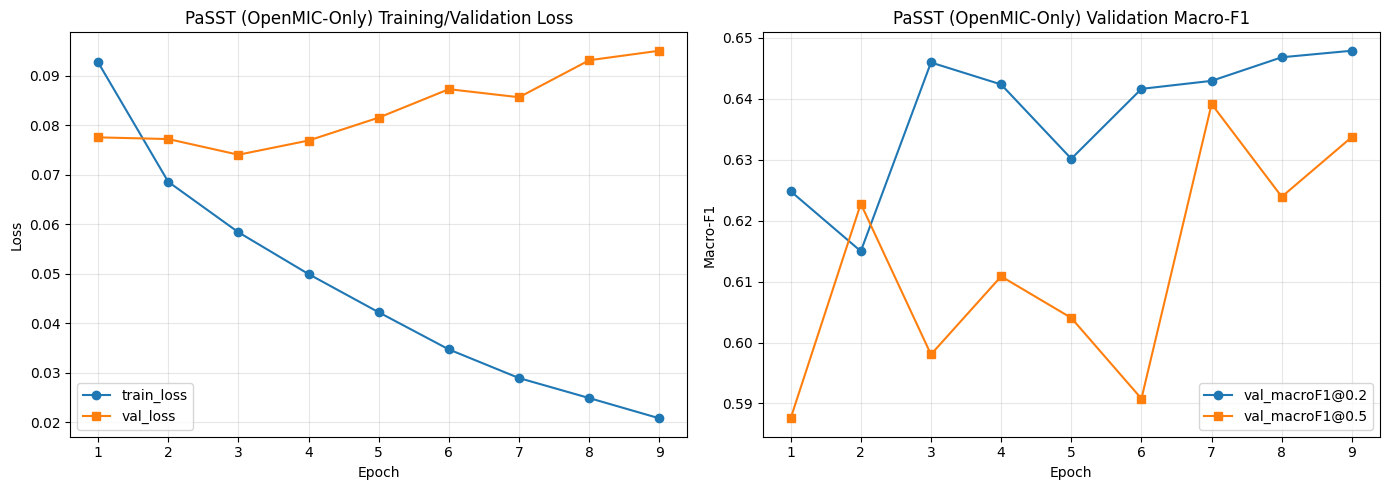

In [16]:
import matplotlib.pyplot as plt

epochs_r = range(1, len(history["train_loss"]) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(list(epochs_r), history["train_loss"], label="train_loss", marker='o')
axes[0].plot(list(epochs_r), history["val_loss"], label="val_loss", marker='s')
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].set_title("PaSST (OpenMIC-Only) Training/Validation Loss")
axes[0].grid(True, alpha=0.3)

axes[1].plot(list(epochs_r), history["val_f1_02"], label="val_macroF1@0.2", marker='o')
axes[1].plot(list(epochs_r), history["val_f1_05"], label="val_macroF1@0.5", marker='s')
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Macro-F1")
axes[1].legend()
axes[1].set_title("PaSST (OpenMIC-Only) Validation Macro-F1")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 12. Comparison Summary

After running this notebook, compare results with the OpenMIC + Synthetic model:

| Model | Test Loss | Macro-F1@0.2 | Macro-F1@0.5 |
|-------|-----------|--------------|---------------|
| OpenMIC + Synthetic | 0.0916 | 0.6707 | 0.6163 |
| OpenMIC Only | 0.0748 | 0.6426 | 0.5744 |

This will help quantify the impact of synthetic data on model performance.


In [17]:
# Save training history for later analysis
history_df = pd.DataFrame(history)
history_df.to_csv("/content/drive/MyDrive/deep_learning/passt_openmic_only_training_history.csv", index=False)
print("Training history saved!")

# Print final comparison
print("\n" + "="*60)
print("COMPARISON: OpenMIC + Synthetic vs OpenMIC Only")
print("="*60)
print(f"\nOpenMIC + Synthetic (from original notebook):")
print(f"  TEST loss: 0.0916")
print(f"  TEST macro-F1@0.2: 0.6707")
print(f"  TEST macro-F1@0.5: 0.6163")
print(f"\nOpenMIC Only (this notebook):")
print(f"  TEST loss: {test_loss:.4f}")
print(f"  TEST macro-F1@0.2: {test_f1_02:.4f}")
print(f"  TEST macro-F1@0.5: {test_f1_05:.4f}")
print(f"\nDifference (Synthetic Impact):")
print(f"  Loss: {0.0916 - test_loss:+.4f}")
print(f"  F1@0.2: {0.6707 - test_f1_02:+.4f}")
print(f"  F1@0.5: {0.6163 - test_f1_05:+.4f}")
print("="*60)


Training history saved!

COMPARISON: OpenMIC + Synthetic vs OpenMIC Only

OpenMIC + Synthetic (from original notebook):
  TEST loss: 0.0916
  TEST macro-F1@0.2: 0.6707
  TEST macro-F1@0.5: 0.6163

OpenMIC Only (this notebook):
  TEST loss: 0.0749
  TEST macro-F1@0.2: 0.6427
  TEST macro-F1@0.5: 0.5744

Difference (Synthetic Impact):
  Loss: +0.0167
  F1@0.2: +0.0280
  F1@0.5: +0.0419


PER-CLASS COMPARISON: OpenMIC + Synthetic vs OpenMIC Only

📊 TOP 10 CLASSES THAT BENEFIT MOST FROM SYNTHETIC DATA (by F1 improvement):
--------------------------------------------------------------------------------
            Class  F1 (Synth)  F1 (OpenMIC)     F1 Δ  Prec (Synth)  Prec (OpenMIC)  Rec (Synth)  Rec (OpenMIC)  Pos (Synth)  Pos (OpenMIC)
             bass    0.677083      0.216216 0.460867      0.643564        1.000000     0.714286       0.121212          182             66
            flute    0.733010      0.307692 0.425317      0.715640        0.909091     0.751244       0.185185          201             54
         mandolin    0.594595      0.301887 0.292708      0.709677        0.727273     0.511628       0.190476           86             84
mallet_percussion    0.745763      0.539326 0.206437      0.693694        0.750000     0.806283       0.421053          191             57
            organ    0.772487      0.600000 0.172487      0.772487        0.710526     0.

/tmp/ipython-input-818828990.py:69: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  freq_analysis = df_merged.groupby("frequency_category")["f1_diff"].agg(['mean', 'count', 'std'])


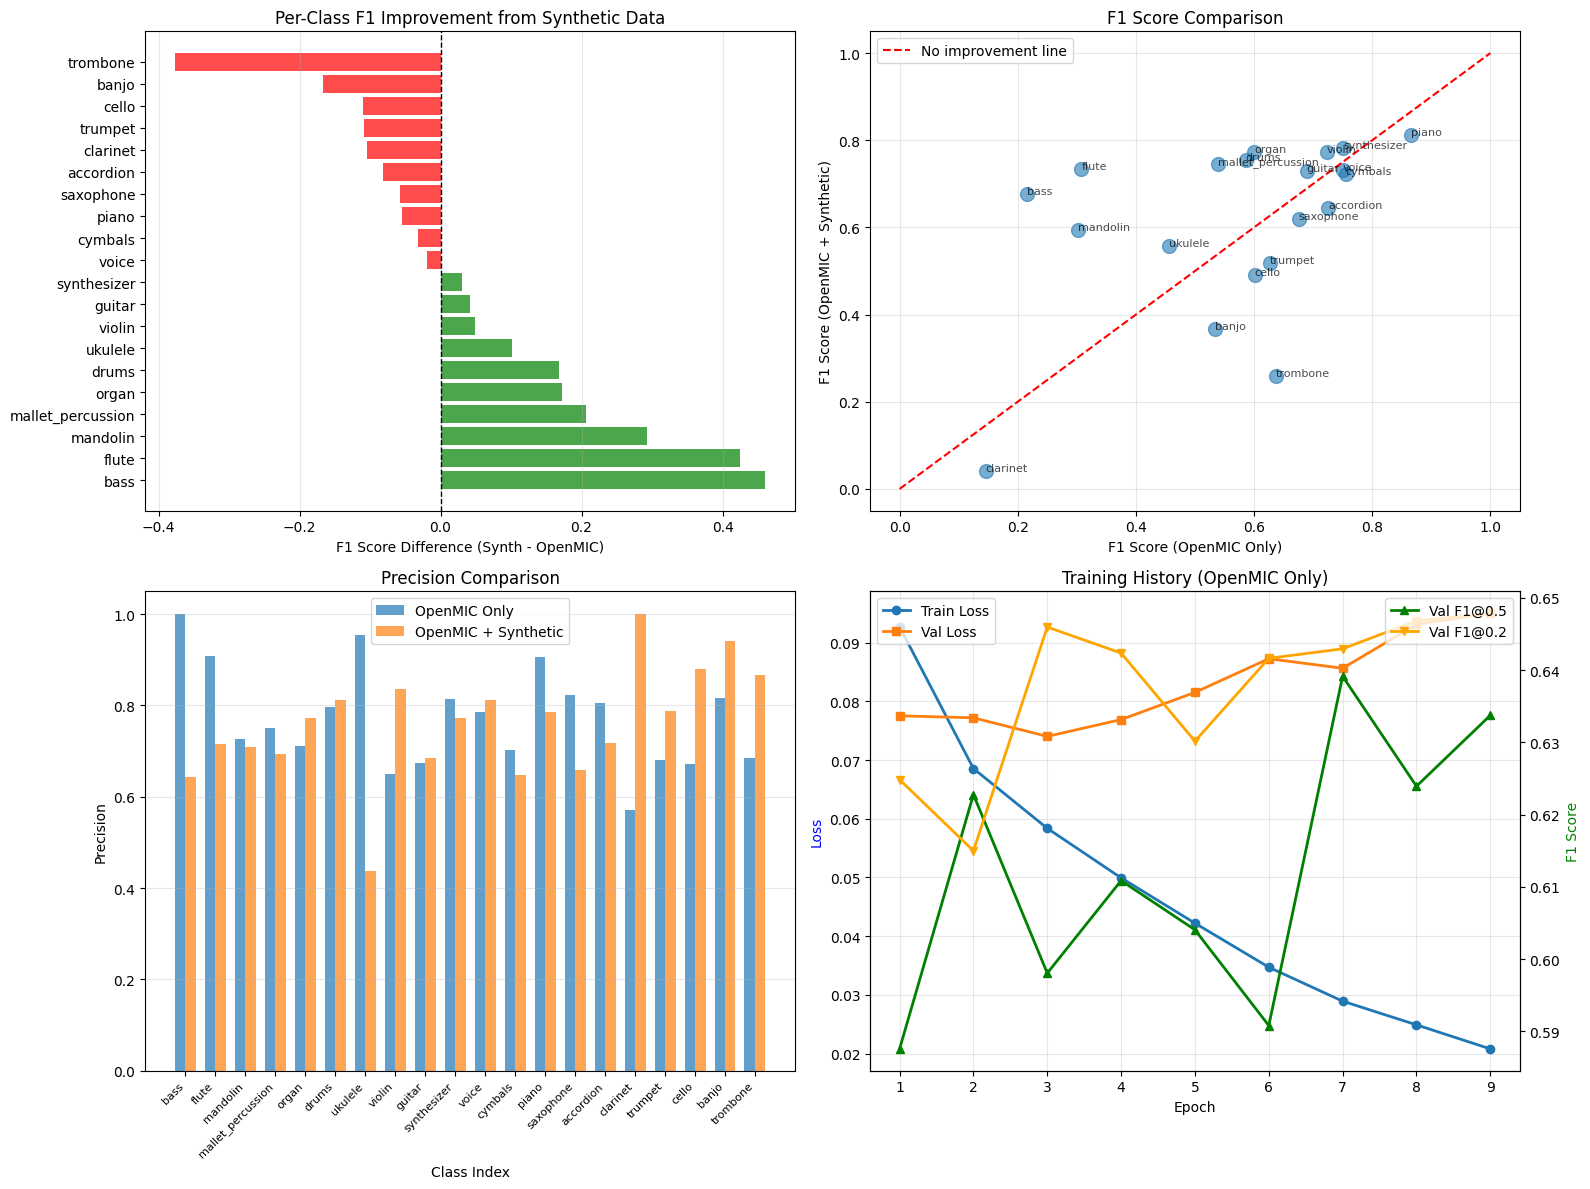


DETAILED PER-CLASS BREAKDOWN
            Class  F1 (OpenMIC)  F1 (Synth)      F1 Δ  Prec (OpenMIC)  Prec (Synth)    Prec Δ  Rec (OpenMIC)  Rec (Synth)     Rec Δ  Positives (OpenMIC)  Positives (Synth)
             bass      0.216216    0.677083  0.460867        1.000000      0.643564 -0.356436       0.121212     0.714286  0.593074                   66                182
            flute      0.307692    0.733010  0.425317        0.909091      0.715640 -0.193451       0.185185     0.751244  0.566059                   54                201
         mandolin      0.301887    0.594595  0.292708        0.727273      0.709677 -0.017595       0.190476     0.511628  0.321152                   84                 86
mallet_percussion      0.539326    0.745763  0.206437        0.750000      0.693694 -0.056306       0.421053     0.806283  0.385230                   57                191
            organ      0.600000    0.772487  0.172487        0.710526      0.772487  0.061960       0.519231  

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load both per-class metrics CSV files
df_synth = pd.read_csv("/content/drive/MyDrive/deep_learning/passt_test_per_class_metrics.csv")
df_openmic = pd.read_csv("/content/drive/MyDrive/deep_learning/passt_openmic_only_test_per_class_metrics.csv")

# Load training history
history_openmic = pd.read_csv("/content/drive/MyDrive/deep_learning/passt_openmic_only_training_history.csv")

print("="*80)
print("PER-CLASS COMPARISON: OpenMIC + Synthetic vs OpenMIC Only")
print("="*80)

# Merge dataframes for comparison
df_merged = df_synth.merge(df_openmic, on="tag", suffixes=("_synth", "_openmic"))
df_merged["f1_diff"] = df_merged["f1_synth"] - df_merged["f1_openmic"]
df_merged["precision_diff"] = df_merged["precision_synth"] - df_merged["precision_openmic"]
df_merged["recall_diff"] = df_merged["recall_synth"] - df_merged["recall_openmic"]

# Sort by F1 difference to see which classes benefit most
df_merged = df_merged.sort_values("f1_diff", ascending=False)

print("\n📊 TOP 10 CLASSES THAT BENEFIT MOST FROM SYNTHETIC DATA (by F1 improvement):")
print("-"*80)
top_benefited = df_merged.head(10)[["tag", "f1_synth", "f1_openmic", "f1_diff",
                                     "precision_synth", "precision_openmic",
                                     "recall_synth", "recall_openmic",
                                     "pos_n_synth", "pos_n_openmic"]]
top_benefited.columns = ["Class", "F1 (Synth)", "F1 (OpenMIC)", "F1 Δ",
                          "Prec (Synth)", "Prec (OpenMIC)",
                          "Rec (Synth)", "Rec (OpenMIC)",
                          "Pos (Synth)", "Pos (OpenMIC)"]
print(top_benefited.to_string(index=False))

print("\n📉 TOP 10 CLASSES THAT BENEFIT LEAST (or hurt by synthetic data):")
print("-"*80)
bottom_benefited = df_merged.tail(10)[["tag", "f1_synth", "f1_openmic", "f1_diff",
                                        "precision_synth", "precision_openmic",
                                        "recall_synth", "recall_openmic"]]
bottom_benefited.columns = ["Class", "F1 (Synth)", "F1 (OpenMIC)", "F1 Δ",
                             "Prec (Synth)", "Prec (OpenMIC)",
                             "Rec (Synth)", "Rec (OpenMIC)"]
print(bottom_benefited.to_string(index=False))

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nClasses with F1 improvement: {(df_merged['f1_diff'] > 0).sum()} / {len(df_merged)}")
print(f"Classes with F1 degradation: {(df_merged['f1_diff'] < 0).sum()} / {len(df_merged)}")
print(f"Classes with no change: {(df_merged['f1_diff'] == 0).sum()} / {len(df_merged)}")
print(f"\nMean F1 improvement: {df_merged['f1_diff'].mean():.4f}")
print(f"Median F1 improvement: {df_merged['f1_diff'].median():.4f}")
print(f"Max F1 improvement: {df_merged['f1_diff'].max():.4f} ({df_merged.loc[df_merged['f1_diff'].idxmax(), 'tag']})")
print(f"Max F1 degradation: {df_merged['f1_diff'].min():.4f} ({df_merged.loc[df_merged['f1_diff'].idxmin(), 'tag']})")

# Analyze by class frequency
print("\n" + "="*80)
print("ANALYSIS BY CLASS FREQUENCY")
print("="*80)
df_merged["pos_n_avg"] = (df_merged["pos_n_synth"] + df_merged["pos_n_openmic"]) / 2
df_merged["frequency_category"] = pd.cut(df_merged["pos_n_avg"],
                                         bins=[0, 50, 150, 500, float('inf')],
                                         labels=["Rare (<50)", "Uncommon (50-150)", "Common (150-500)", "Frequent (>500)"])

freq_analysis = df_merged.groupby("frequency_category")["f1_diff"].agg(['mean', 'count', 'std'])
print("\nAverage F1 improvement by class frequency:")
print(freq_analysis)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. F1 difference bar chart
ax1 = axes[0, 0]
colors = ['green' if x > 0 else 'red' for x in df_merged['f1_diff']]
ax1.barh(df_merged['tag'], df_merged['f1_diff'], color=colors, alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax1.set_xlabel('F1 Score Difference (Synth - OpenMIC)')
ax1.set_title('Per-Class F1 Improvement from Synthetic Data')
ax1.grid(axis='x', alpha=0.3)

# 2. Scatter: F1 OpenMIC vs F1 Synthetic
ax2 = axes[0, 1]
ax2.scatter(df_merged['f1_openmic'], df_merged['f1_synth'], alpha=0.6, s=100)
ax2.plot([0, 1], [0, 1], 'r--', label='No improvement line')
ax2.set_xlabel('F1 Score (OpenMIC Only)')
ax2.set_ylabel('F1 Score (OpenMIC + Synthetic)')
ax2.set_title('F1 Score Comparison')
ax2.legend()
ax2.grid(alpha=0.3)
# Add class labels
for idx, row in df_merged.iterrows():
    ax2.annotate(row['tag'], (row['f1_openmic'], row['f1_synth']),
                 fontsize=8, alpha=0.7)

# 3. Precision vs Recall comparison
ax3 = axes[1, 0]
x_pos = np.arange(len(df_merged))
width = 0.35
ax3.bar(x_pos - width/2, df_merged['precision_openmic'], width, label='OpenMIC Only', alpha=0.7)
ax3.bar(x_pos + width/2, df_merged['precision_synth'], width, label='OpenMIC + Synthetic', alpha=0.7)
ax3.set_xlabel('Class Index')
ax3.set_ylabel('Precision')
ax3.set_title('Precision Comparison')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(df_merged['tag'], rotation=45, ha='right', fontsize=8)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. Training history curves
ax4 = axes[1, 1]
epochs = range(1, len(history_openmic) + 1)
ax4.plot(epochs, history_openmic['train_loss'], 'o-', label='Train Loss', linewidth=2)
ax4.plot(epochs, history_openmic['val_loss'], 's-', label='Val Loss', linewidth=2)
ax4_twin = ax4.twinx()
ax4_twin.plot(epochs, history_openmic['val_f1_05'], '^-', label='Val F1@0.5',
              color='green', linewidth=2)
ax4_twin.plot(epochs, history_openmic['val_f1_02'], 'v-', label='Val F1@0.2',
              color='orange', linewidth=2)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss', color='blue')
ax4_twin.set_ylabel('F1 Score', color='green')
ax4.set_title('Training History (OpenMIC Only)')
ax4.legend(loc='upper left')
ax4_twin.legend(loc='upper right')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Detailed per-class breakdown
print("\n" + "="*80)
print("DETAILED PER-CLASS BREAKDOWN")
print("="*80)
detailed = df_merged[["tag", "f1_openmic", "f1_synth", "f1_diff",
                      "precision_openmic", "precision_synth", "precision_diff",
                      "recall_openmic", "recall_synth", "recall_diff",
                      "pos_n_openmic", "pos_n_synth"]].copy()
detailed.columns = ["Class", "F1 (OpenMIC)", "F1 (Synth)", "F1 Δ",
                     "Prec (OpenMIC)", "Prec (Synth)", "Prec Δ",
                     "Rec (OpenMIC)", "Rec (Synth)", "Rec Δ",
                     "Positives (OpenMIC)", "Positives (Synth)"]
print(detailed.to_string(index=False))

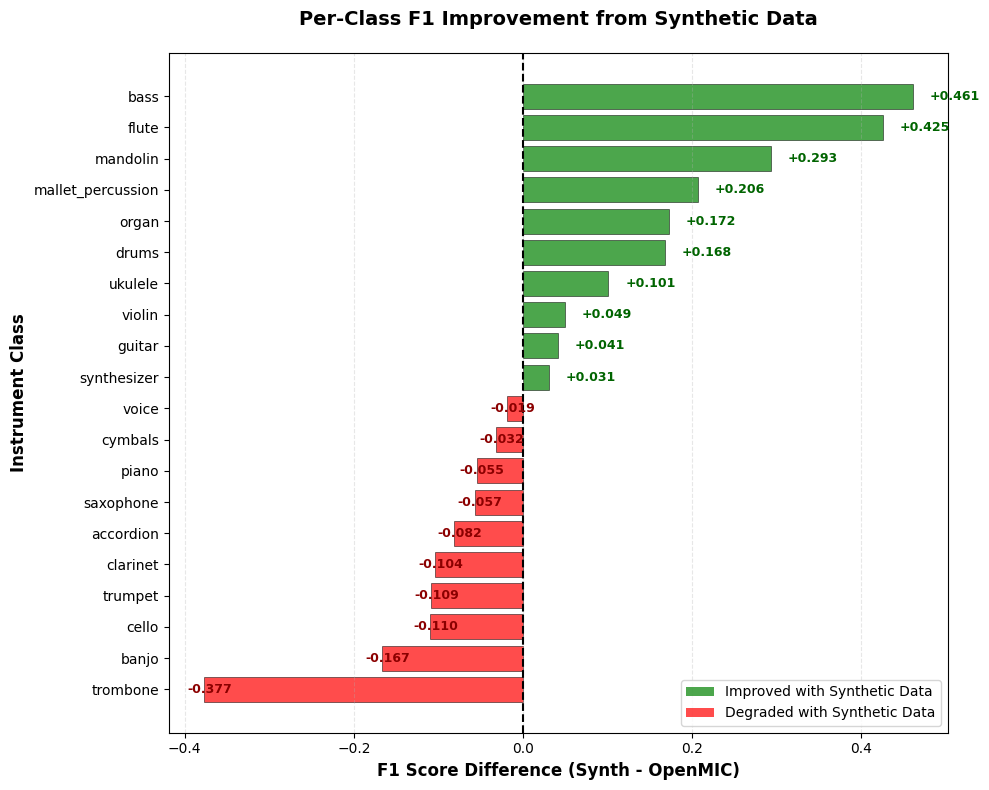

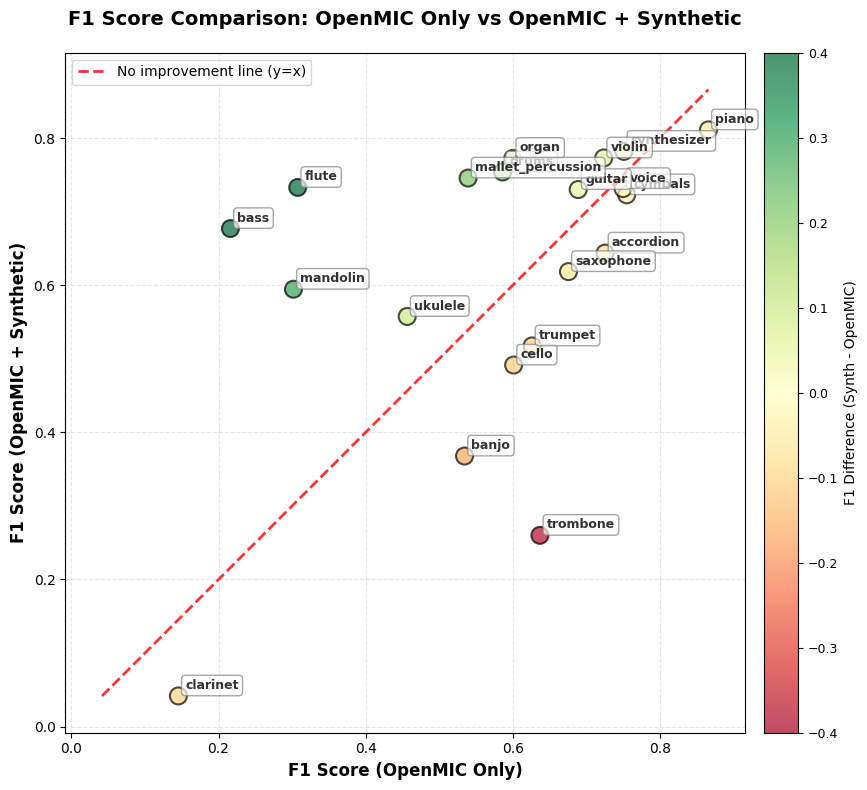

SUMMARY STATISTICS

Classes with F1 improvement: 10 / 20
Classes with F1 degradation: 10 / 20

Mean F1 improvement: 0.0419
Median F1 improvement: 0.0062

Top 3 improvements:
  bass: 0.216 → 0.677 (Δ+0.461)
  flute: 0.308 → 0.733 (Δ+0.425)
  mandolin: 0.302 → 0.595 (Δ+0.293)

Top 3 degradations:
  trombone: 0.637 → 0.260 (Δ-0.377)
  banjo: 0.534 → 0.368 (Δ-0.167)
  cello: 0.601 → 0.492 (Δ-0.110)


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load both per-class metrics CSV files
df_synth = pd.read_csv("/content/drive/MyDrive/deep_learning/passt_test_per_class_metrics.csv")
df_openmic = pd.read_csv("/content/drive/MyDrive/deep_learning/passt_openmic_only_test_per_class_metrics.csv")

# Merge dataframes for comparison
df_merged = df_synth.merge(df_openmic, on="tag", suffixes=("_synth", "_openmic"))
df_merged["f1_diff"] = df_merged["f1_synth"] - df_merged["f1_openmic"]

# Sort by F1 difference for better visualization
df_merged = df_merged.sort_values("f1_diff", ascending=True)

# ============================================================================
# PLOT 1: Per-Class F1 Improvement from Synthetic Data (Horizontal Bar Chart)
# ============================================================================
plt.figure(figsize=(10, 8))

# Color bars: green for improvement, red for degradation
colors = ['green' if x > 0 else 'red' for x in df_merged['f1_diff']]

# Create horizontal bar chart
bars = plt.barh(df_merged['tag'], df_merged['f1_diff'], color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)

# Add vertical line at zero
plt.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='No change')

# Customize plot
plt.xlabel('F1 Score Difference (Synth - OpenMIC)', fontsize=12, fontweight='bold')
plt.ylabel('Instrument Class', fontsize=12, fontweight='bold')
plt.title('Per-Class F1 Improvement from Synthetic Data', fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (idx, row) in enumerate(df_merged.iterrows()):
    diff = row['f1_diff']
    # Position label at the end of the bar
    x_pos = diff + (0.02 if diff > 0 else -0.02)
    plt.text(x_pos, i, f'{diff:+.3f}',
             va='center', fontsize=9, fontweight='bold',
             color='darkgreen' if diff > 0 else 'darkred')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Improved with Synthetic Data'),
    Patch(facecolor='red', alpha=0.7, label='Degraded with Synthetic Data')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

# ============================================================================
# PLOT 2: F1 Score Comparison (Scatter Plot)
# ============================================================================
plt.figure(figsize=(10, 8))

# Create scatter plot
scatter = plt.scatter(df_merged['f1_openmic'], df_merged['f1_synth'],
                      s=150, alpha=0.7, edgecolors='black', linewidth=1.5,
                      c=df_merged['f1_diff'], cmap='RdYlGn', vmin=-0.4, vmax=0.4)

# Add diagonal line (y=x) for reference
max_val = max(df_merged['f1_openmic'].max(), df_merged['f1_synth'].max())
min_val = min(df_merged['f1_openmic'].min(), df_merged['f1_synth'].min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--',
         linewidth=2, label='No improvement line (y=x)', alpha=0.8)

# Add class labels
for idx, row in df_merged.iterrows():
    plt.annotate(row['tag'],
                (row['f1_openmic'], row['f1_synth']),
                fontsize=9, alpha=0.8, fontweight='bold',
                xytext=(5, 5), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray'))

# Customize plot
plt.xlabel('F1 Score (OpenMIC Only)', fontsize=12, fontweight='bold')
plt.ylabel('F1 Score (OpenMIC + Synthetic)', fontsize=12, fontweight='bold')
plt.title('F1 Score Comparison: OpenMIC Only vs OpenMIC + Synthetic',
          fontsize=14, fontweight='bold', pad=20)
plt.grid(alpha=0.3, linestyle='--')
plt.legend(loc='upper left', fontsize=10)

# Add colorbar
cbar = plt.colorbar(scatter, label='F1 Difference (Synth - OpenMIC)', pad=0.02)
cbar.ax.tick_params(labelsize=9)

# Set equal aspect ratio and limits
plt.xlim([min_val - 0.05, max_val + 0.05])
plt.ylim([min_val - 0.05, max_val + 0.05])
plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# Print summary statistics
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"\nClasses with F1 improvement: {(df_merged['f1_diff'] > 0).sum()} / {len(df_merged)}")
print(f"Classes with F1 degradation: {(df_merged['f1_diff'] < 0).sum()} / {len(df_merged)}")
print(f"\nMean F1 improvement: {df_merged['f1_diff'].mean():.4f}")
print(f"Median F1 improvement: {df_merged['f1_diff'].median():.4f}")
print(f"\nTop 3 improvements:")
top_3 = df_merged.nlargest(3, 'f1_diff')[['tag', 'f1_openmic', 'f1_synth', 'f1_diff']]
for idx, row in top_3.iterrows():
    print(f"  {row['tag']}: {row['f1_openmic']:.3f} → {row['f1_synth']:.3f} (Δ{row['f1_diff']:+.3f})")
print(f"\nTop 3 degradations:")
bottom_3 = df_merged.nsmallest(3, 'f1_diff')[['tag', 'f1_openmic', 'f1_synth', 'f1_diff']]
for idx, row in bottom_3.iterrows():
    print(f"  {row['tag']}: {row['f1_openmic']:.3f} → {row['f1_synth']:.3f} (Δ{row['f1_diff']:+.3f})")